# Calculating return period for cyclones in Madagascar


## Using La Reunion forecasts

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src import constants
from src.datasources import codab, rsmc

c:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-mdg-storms\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adm0_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

In [4]:
df = rsmc.load_historical_forecast_distances()
distance_cols = [x for x in df.columns if "_distance_km" in x]
df["any_distance_km"] = df[distance_cols].min(axis=1)

In [5]:
df["name"].unique()

array(['0120102011', 'ALENGA', 'ANAIS', '0120132014', 'ADJALI',
       'ANNABELLE', 'ABELA', 'AVA', '0120182019', '0120192020', 'ALICIA',
       'ANA', 'ASHLEY', 'ALVARO', 'ABELE', '0220112012', '0220122013',
       'AMARA', '0220142015', 'BOHALE', 'BRANSBY', 'IRVING', 'ALCIDE',
       'BELNA', '0220202021', 'BATSIRAI', 'BALITA', 'BELAL', '0320112012',
       'BOLDWIN', 'BRUCE', 'BAKUNG', 'CORENTIN', '0320162017',
       'BERGUITTA', 'BOUCHRA', 'AMBALI', 'BONGOYO', 'CLIFF', '0320222023',
       'CANDICE', '0420102011', 'BENILDE', 'CLAUDIA', 'BEJISA', 'KATE',
       'DAYA', 'CARLOS', '0420172018', 'KENANGA', 'CALVINIA', 'CHALANE',
       'DUMAKO', 'DARIAN', 'ANGGREK', 'BINGIZA', 'CHANDA', 'DUMILE',
       '0520132014', 'BANSI', 'URIAH', 'DINEO', 'CEBILE', 'CILIDA',
       '0520192020', '0520202021', 'EMNATI', 'CHENESO', '0520232024',
       '0620102011', 'DANDO', 'EMANG', 'COLIN', 'CHEDZA', 'EMERAUDE',
       'ENAWO', 'DUMAZILE', 'DESMOND', 'DIANE', 'DANILO', 'FEZILE',
       'DINGANI',

In [6]:
df_rsmc_gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326",
)

In [7]:
df_rsmc_gdf[df_rsmc_gdf["any_distance_km"] == 0]["name"].unique()

array(['ANAIS', '0120132014', 'ABELA', 'AVA', 'ANA', 'ALVARO', 'BELNA',
       'BATSIRAI', 'CHALANE', 'DUMAKO', 'BINGIZA', 'CHANDA', 'EMNATI',
       'CHENESO', 'CHEDZA', 'ENAWO', 'DIANE', 'ELIAKIM', 'ELOISE',
       'FREDDY', 'ELEANOR', '0820132014', 'FRANCISCO', 'FILIPO',
       'GIOVANNA', 'HARUNA', 'GOMBE', 'GAMANE', 'IRINA', '1120142015',
       'JASMINE', 'HELLEN', 'IMAN'], dtype=object)

Text(0.5, 1.0, 'Forecast of Cyclone Gamane')

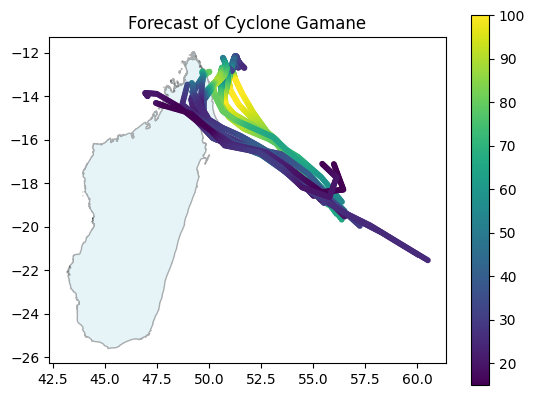

In [8]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
df_rsmc_gdf[df_rsmc_gdf["name"] == "GAMANE"].plot(
    ax=ax, column="max_wind_kt", markersize=10, legend=True
)
plt.title("Forecast of Cyclone Gamane")

In [9]:
# Define scenarios
scenarios = [2, 2.5, 3]

# List to store results
dicts = []

# Loop over lead times and scenarios
for max_lt in range(0, 121, 12):
    for scenario in scenarios:
        if scenario == 2:
            # Scenario 2: 100 km, 64 knots
            rp = rsmc.calculate_rp(
                df,
                max_lt=max_lt,
                pcode="any",
                distance_thresh=100,
                wind_thresh=64,
                scenario=scenario,
            )

        elif scenario == 2.5:
            # Scenario 2.5: Combined thresholds (64 knots at 0 km, 90 knots at 100 km)
            rp = rsmc.calculate_rp(
                df,
                max_lt=max_lt,
                pcode="any",
                scenario=scenario,  # scenario=2.5 triggers combined threshold behavior
            )

        elif scenario == 3:
            # Scenario 3: 100 km, 90 knots
            rp = rsmc.calculate_rp(
                df,
                max_lt=max_lt,
                pcode="any",
                distance_thresh=100,
                wind_thresh=90,
                scenario=scenario,
            )

        # Store results
        dicts.append(
            {
                "scenario": scenario,
                "max_lt": max_lt,
                "rp": rp,
            }
        )

# Convert results to DataFrame
df_rps = pd.DataFrame(dicts)
df_rps = df_rps[df_rps["scenario"].isin([2.0, 3.0])]

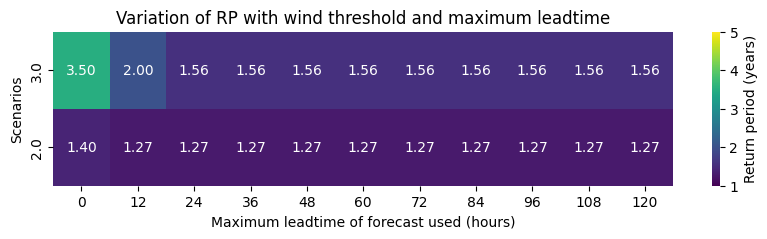

In [10]:
heatmap_data = df_rps.pivot(index="scenario", columns="max_lt", values="rp")

fig, ax = plt.subplots(figsize=(10, 2))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    ax=ax,
    vmax=5,
    vmin=1,
    cmap="viridis",
    cbar_kws={"label": "Return period (years)"},
)

ax.set_xlabel("Maximum leadtime of forecast used (hours)")
ax.set_ylabel("Scenarios")
ax.set_title("Variation of RP with wind threshold and maximum leadtime")
ax.invert_yaxis()
plt.show()